# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2 toc-item"><a href="#bias-in-recorded-daily-minima-and-maxima-induced-by-time-of-measurement" data-toc-modified-id="bias-in-recorded-daily-minima-and-maxima-induced-by-time-of-measurement-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>bias in recorded daily minima and maxima induced by time of measurement</a></div><div class="lev1 toc-item"><a href="#Model-Specification" data-toc-modified-id="Model-Specification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Specification</a></div><div class="lev1 toc-item"><a href="#Implementation" data-toc-modified-id="Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation</a></div><div class="lev1 toc-item"><a href="#Improving-model" data-toc-modified-id="Improving-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Improving model</a></div><div class="lev1 toc-item"><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

In [4]:
using TimeSeries
using DataFrames
using Proj4
using DataFrames: head
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
include("src/preprocessing.jl")
include("src/utils.jl")
isdList=read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
hourly_cat=read_Stations(isdSubset)
TnTx_dict = Dict{Hour,DataFrame}()
for hr in 0:24
    hr_measure = Hour(hr) # number between 0 and 24
    hourly_cat[:ts_day] = [measurement_date(t, hr_measure) for t in hourly_cat[:ts].values]

    TnTx = DataFrames.by(hourly_cat, [:ts_day, :station], df -> DataFrame(
        Tn=minimum(df[:temp].values), 
        Tx=maximum(df[:temp].values)))
    TnTx_dict[hr_measure] = TnTx
end
waterloo = hourly_cat[hourly_cat[:station].values.==3,:]
waterloo_TnTx_dict = Dict{Hour,DataFrame}()
for hr in Hour(0):Hour(24)
    waterloo[:ts_day] = [measurement_date(t, hr) for t in waterloo[:ts].values]
    TnTx = DataFrames.by(waterloo, :ts_day, df -> DataFrame(
            Tn=minimum(df[:temp].values), 
            Tx=maximum(df[:temp].values),
            Tn_time=df[:ts].values[indmin(df[:temp].values)],
            Tx_time=df[:ts].values[indmax(df[:temp].values)],
            ))
    waterloo_TnTx_dict[hr] = TnTx
end

In [10]:
begin
    hr = Hour(23)
    low = Hour(8)
    peak = Hour(20)
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    apr3_low = TnTx_low[TnTx_low[:ts_day].values.==DateTime(2015,4,4),:]
    apr3_peak = TnTx_peak[TnTx_peak[:ts_day].values.==DateTime(2015,4,4),:]
    
    global apr3_realmax = get(apr3_low[1,:Tx])
    global apr3_measured = get(apr3_peak[1,:Tx])
    println(apr3_realmax)
    println(apr3_measured)
end

7.2
15.6


# Introduction

* explain the problem we're trying to solve

## bias in recorded daily minima and maxima induced by time of measurement

* explain
* demonstrate using hourly temperatures from one station: reduce to daily min and max and show difference as a function of measurement hour

We illustrate the measurement bias in daily maxima and minima with ten days of hourly temperature measurements from the Waterloo Municipal Airport station in Iowa. 
Ideally, $\Tx$ measurements should capture the peak of each diurnal cycle, and $\Tn$ its trough. 
In Figure X, those ideal measurements are indicated by the red and blue triangles respectively. 
The actual measurements are obtained by dividing the data into 24 hour measurement windows, and extracting the minimum and maximum. 
For each window, we plot these extrema with a red and blue horizontal line.

Most of the time, the ideal measurement and the actual measurement coincide: the triangle is on that day's line. 
But there are also several misses. The most blatant example occurs on April 3rd, 
where the peak of the diurnal cycle is {{apr3_realmax}}°C and occurs at 21:00 UTC. 
However, because the previous day was much warmer, the day's $\Tx$ record of {{apr3_measured}}°C is reached immediately after the previous day's measurement. 
The measured $\Tx$ therefore overestimates the diurnal cycle's peak by {{round(apr3_measured-apr3_realmax,1)}}°C.

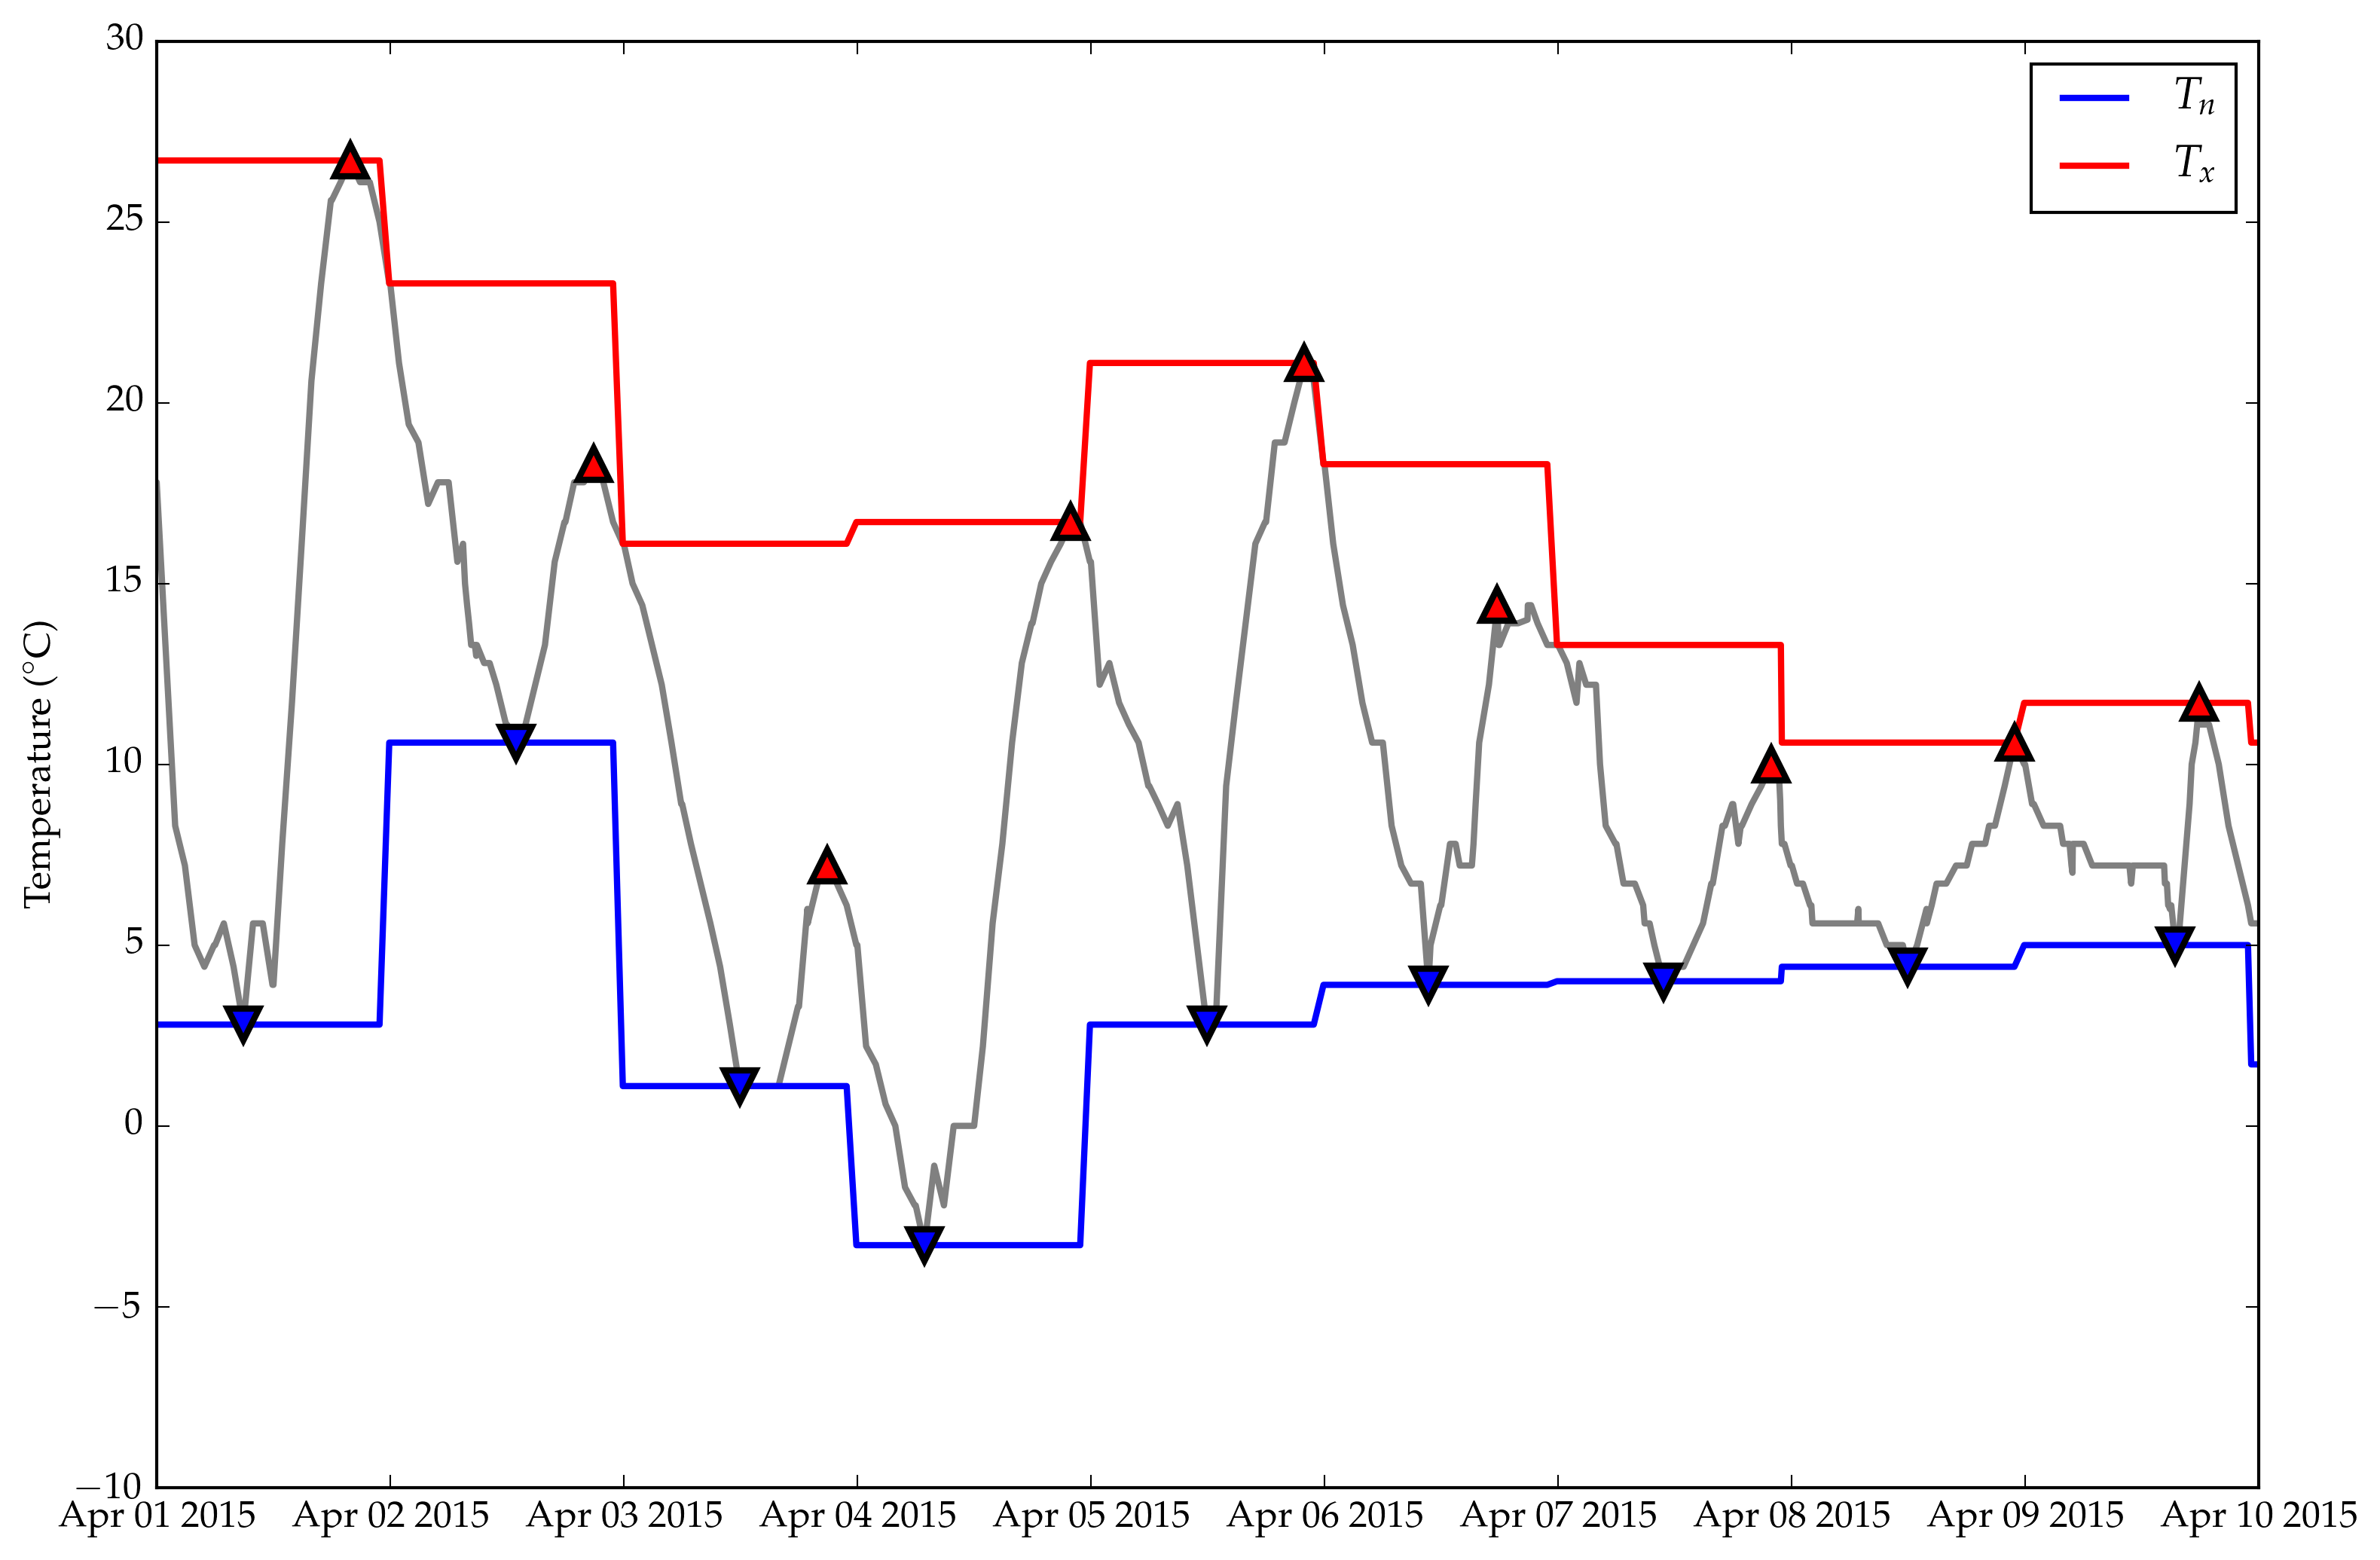

In [14]:
begin
    hr = Hour(23)
    peak = Hour(20)
    low = Hour(8)
    waterloo[:ts_day] = [measurement_date(t,hr) for t in waterloo[:ts].values]
    test_trimmed = join(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    plt.plot(test_trimmed[:ts].values, test_trimmed[:temp].values, color="grey", linewidth=2)
    plt.plot(test_trimmed[:ts].values, test_trimmed[:Tn].values, color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test_trimmed[:ts].values, test_trimmed[:Tx].values, color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    plt.plot(TnTx_low[:Tx_time].values, TnTx_low[:Tx].values, 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=10,
        )
    plt.plot(TnTx_peak[:Tn_time].values, TnTx_peak[:Tn].values, 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=10,
        )
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,10)) # random interval
    plt.ylim(-10,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
    plt.legend()
end;

This subtle bias in the daily records can in turn bias long-term summary statistics that are of climatological interest. 
A measure as simple as the average daily maximum temperature for an entire year (2015) increases by over 1°C if the measurements are made at the warmest time of day 21:00 UTC rather than 14:00 UTC (see Figure X).
Conversely, the average $\Tn$ is colder by over 1°C if $\Tn$ is measured at 10:00 UTC (the coldest time of day on average) rather than 17:00 UTC.

A climatologist studying weather variability might be interested in summary statistics such as the average absolute change in the daily temperature maxima and minima from one day to the next.
The answer to that question too depends on the time of day at which the temperatures are recorded.
Collecting the measurements at the hottest time of day means that the peaks on a warm day gets recorded twice, 
erasing the diurnal peaks of the following colder day, 
and hence the variability gets underestimated.
We can see this in Figure X, where the respective variability estimates drop if the maxima get measured at the warmest time, or if the minima get measured at the coldest time.

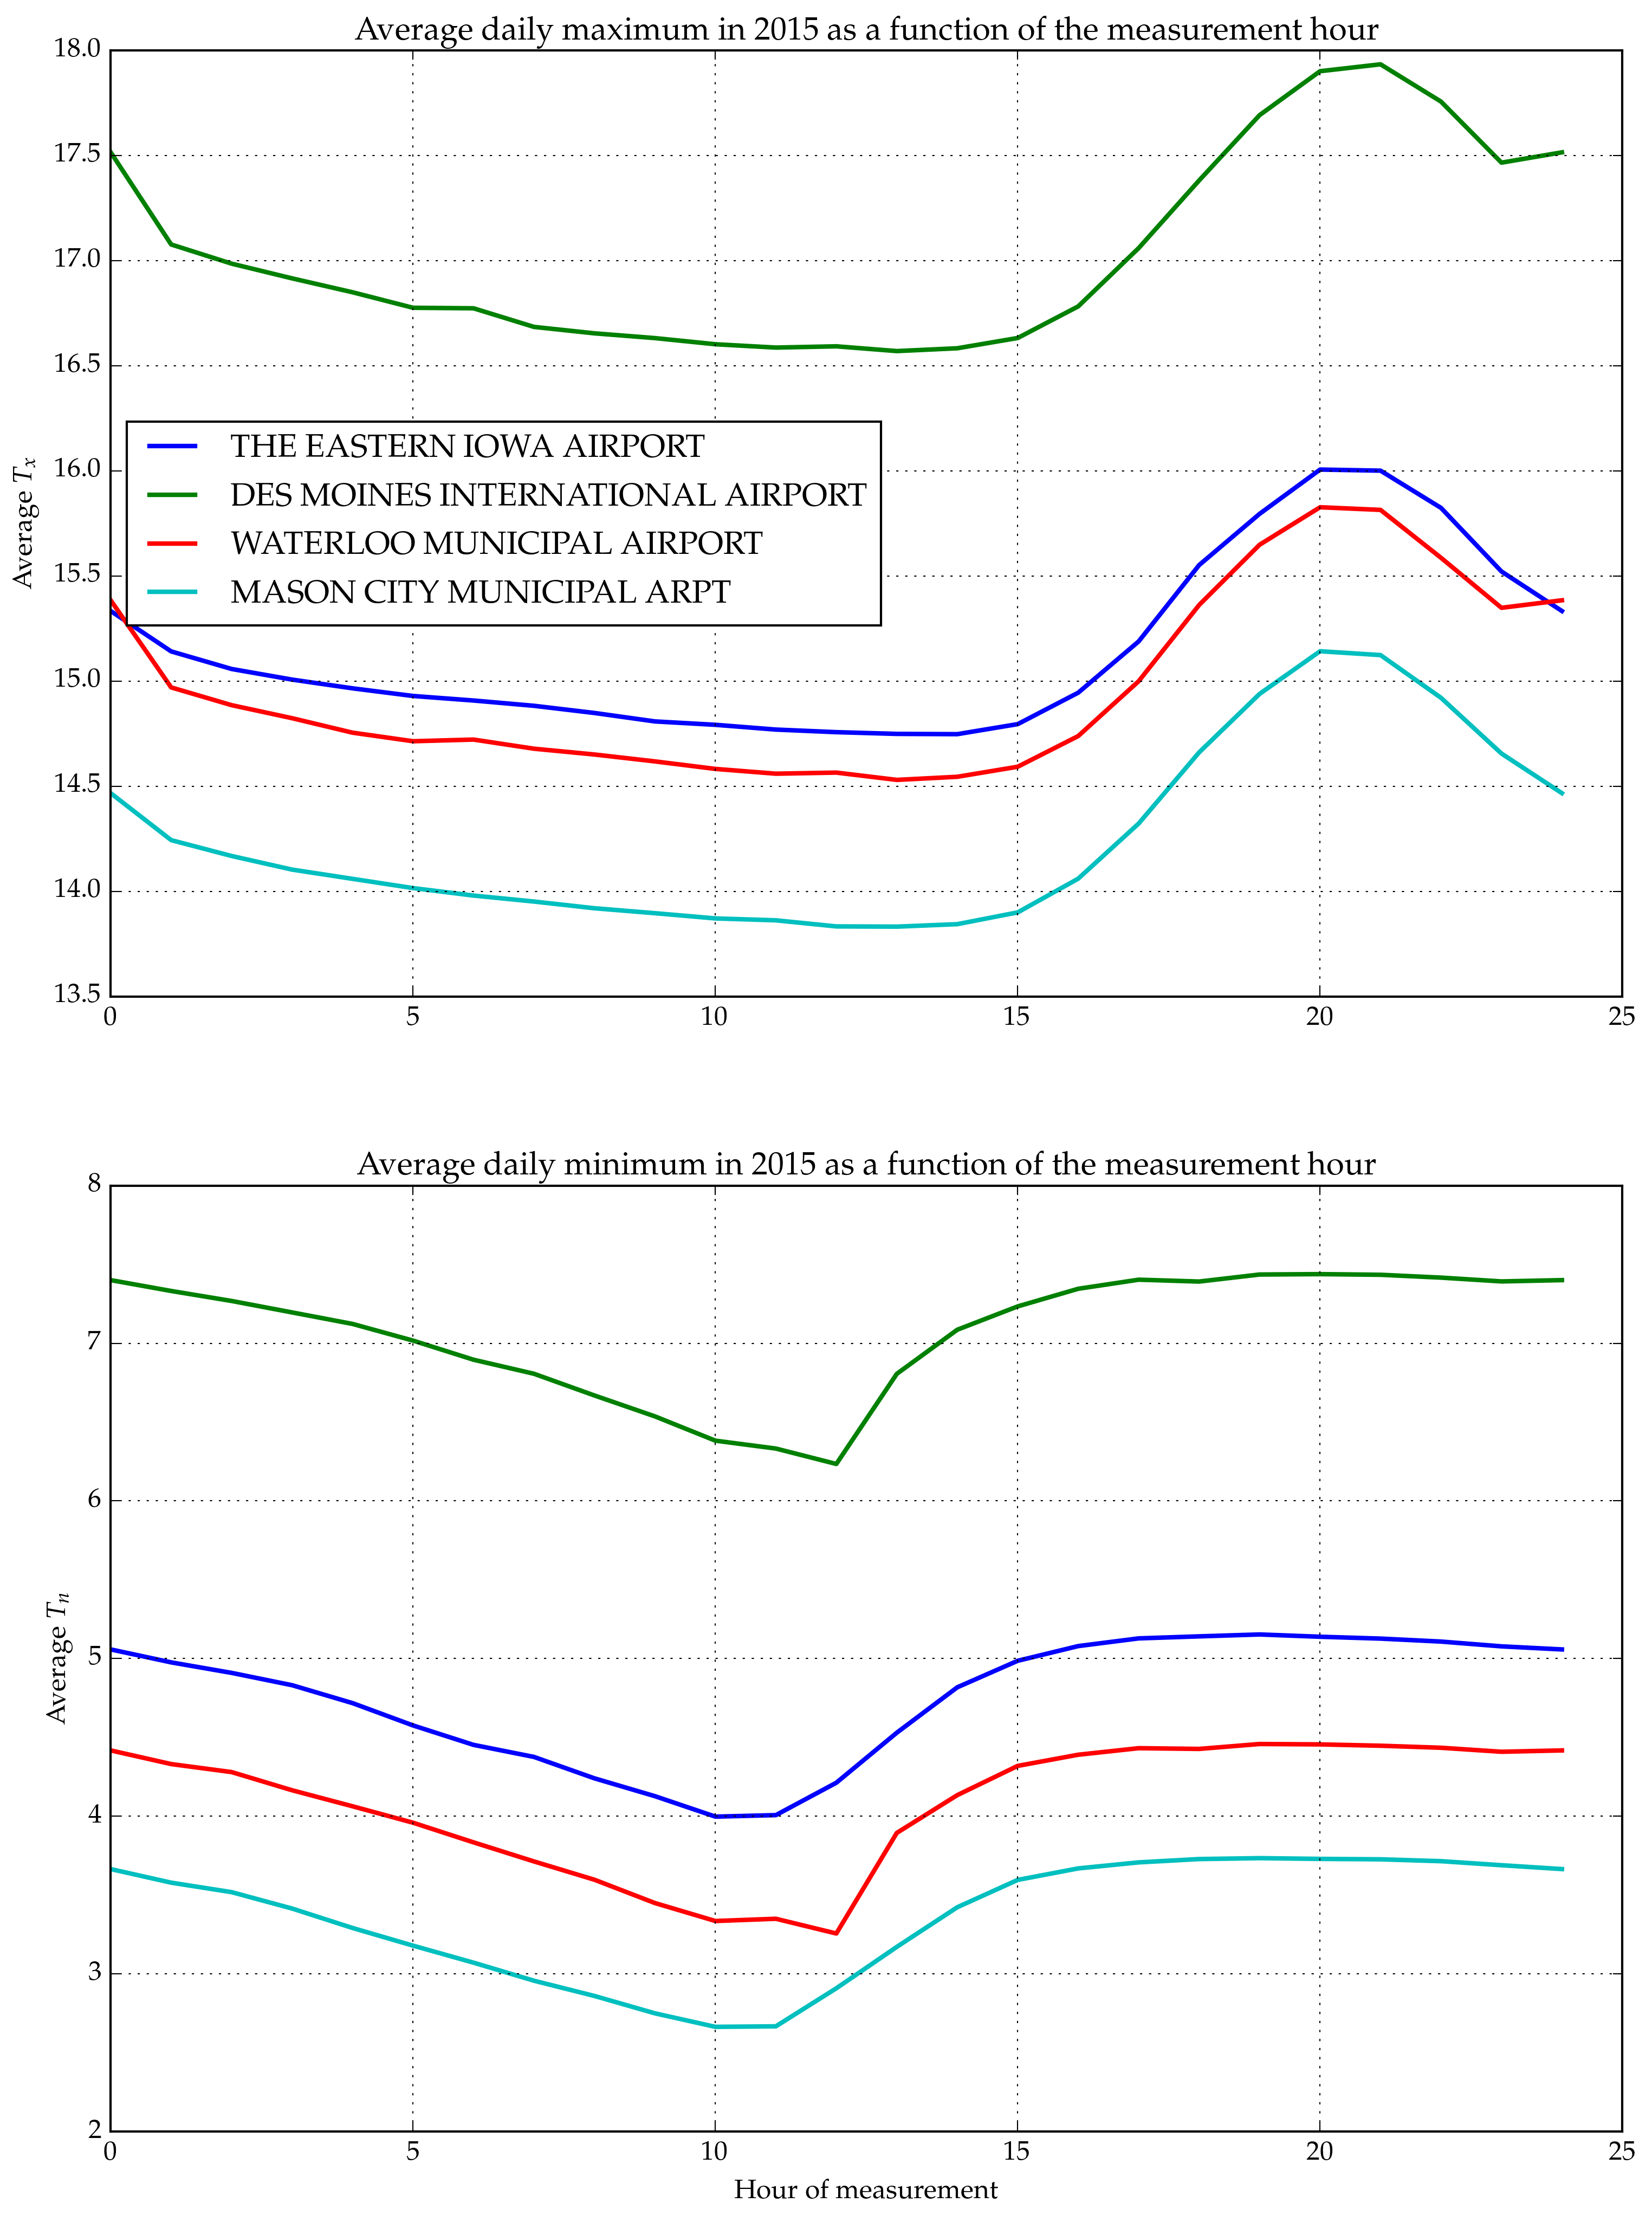

In [40]:
begin
plt.subplot(2,1,1)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(df[:Tx].values))
        for station in 1:4
            push!(statdict[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, statdict[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"Average $T_x$")
    plt.title("Average daily maximum in 2015 as a function of the measurement hour")
    plt.grid(true)
    plt.legend(loc="center left")
end
plt.subplot(2,1,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(df[:Tn].values))
        for station in 1:4
            push!(statdict[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, statdict[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"Average $T_n$")
    plt.xlabel("Hour of measurement")
    plt.title("Average daily minimum in 2015 as a function of the measurement hour")
    plt.grid(true)
end
plt.gcf()[:set_size_inches](12.0, 16.0)
end;

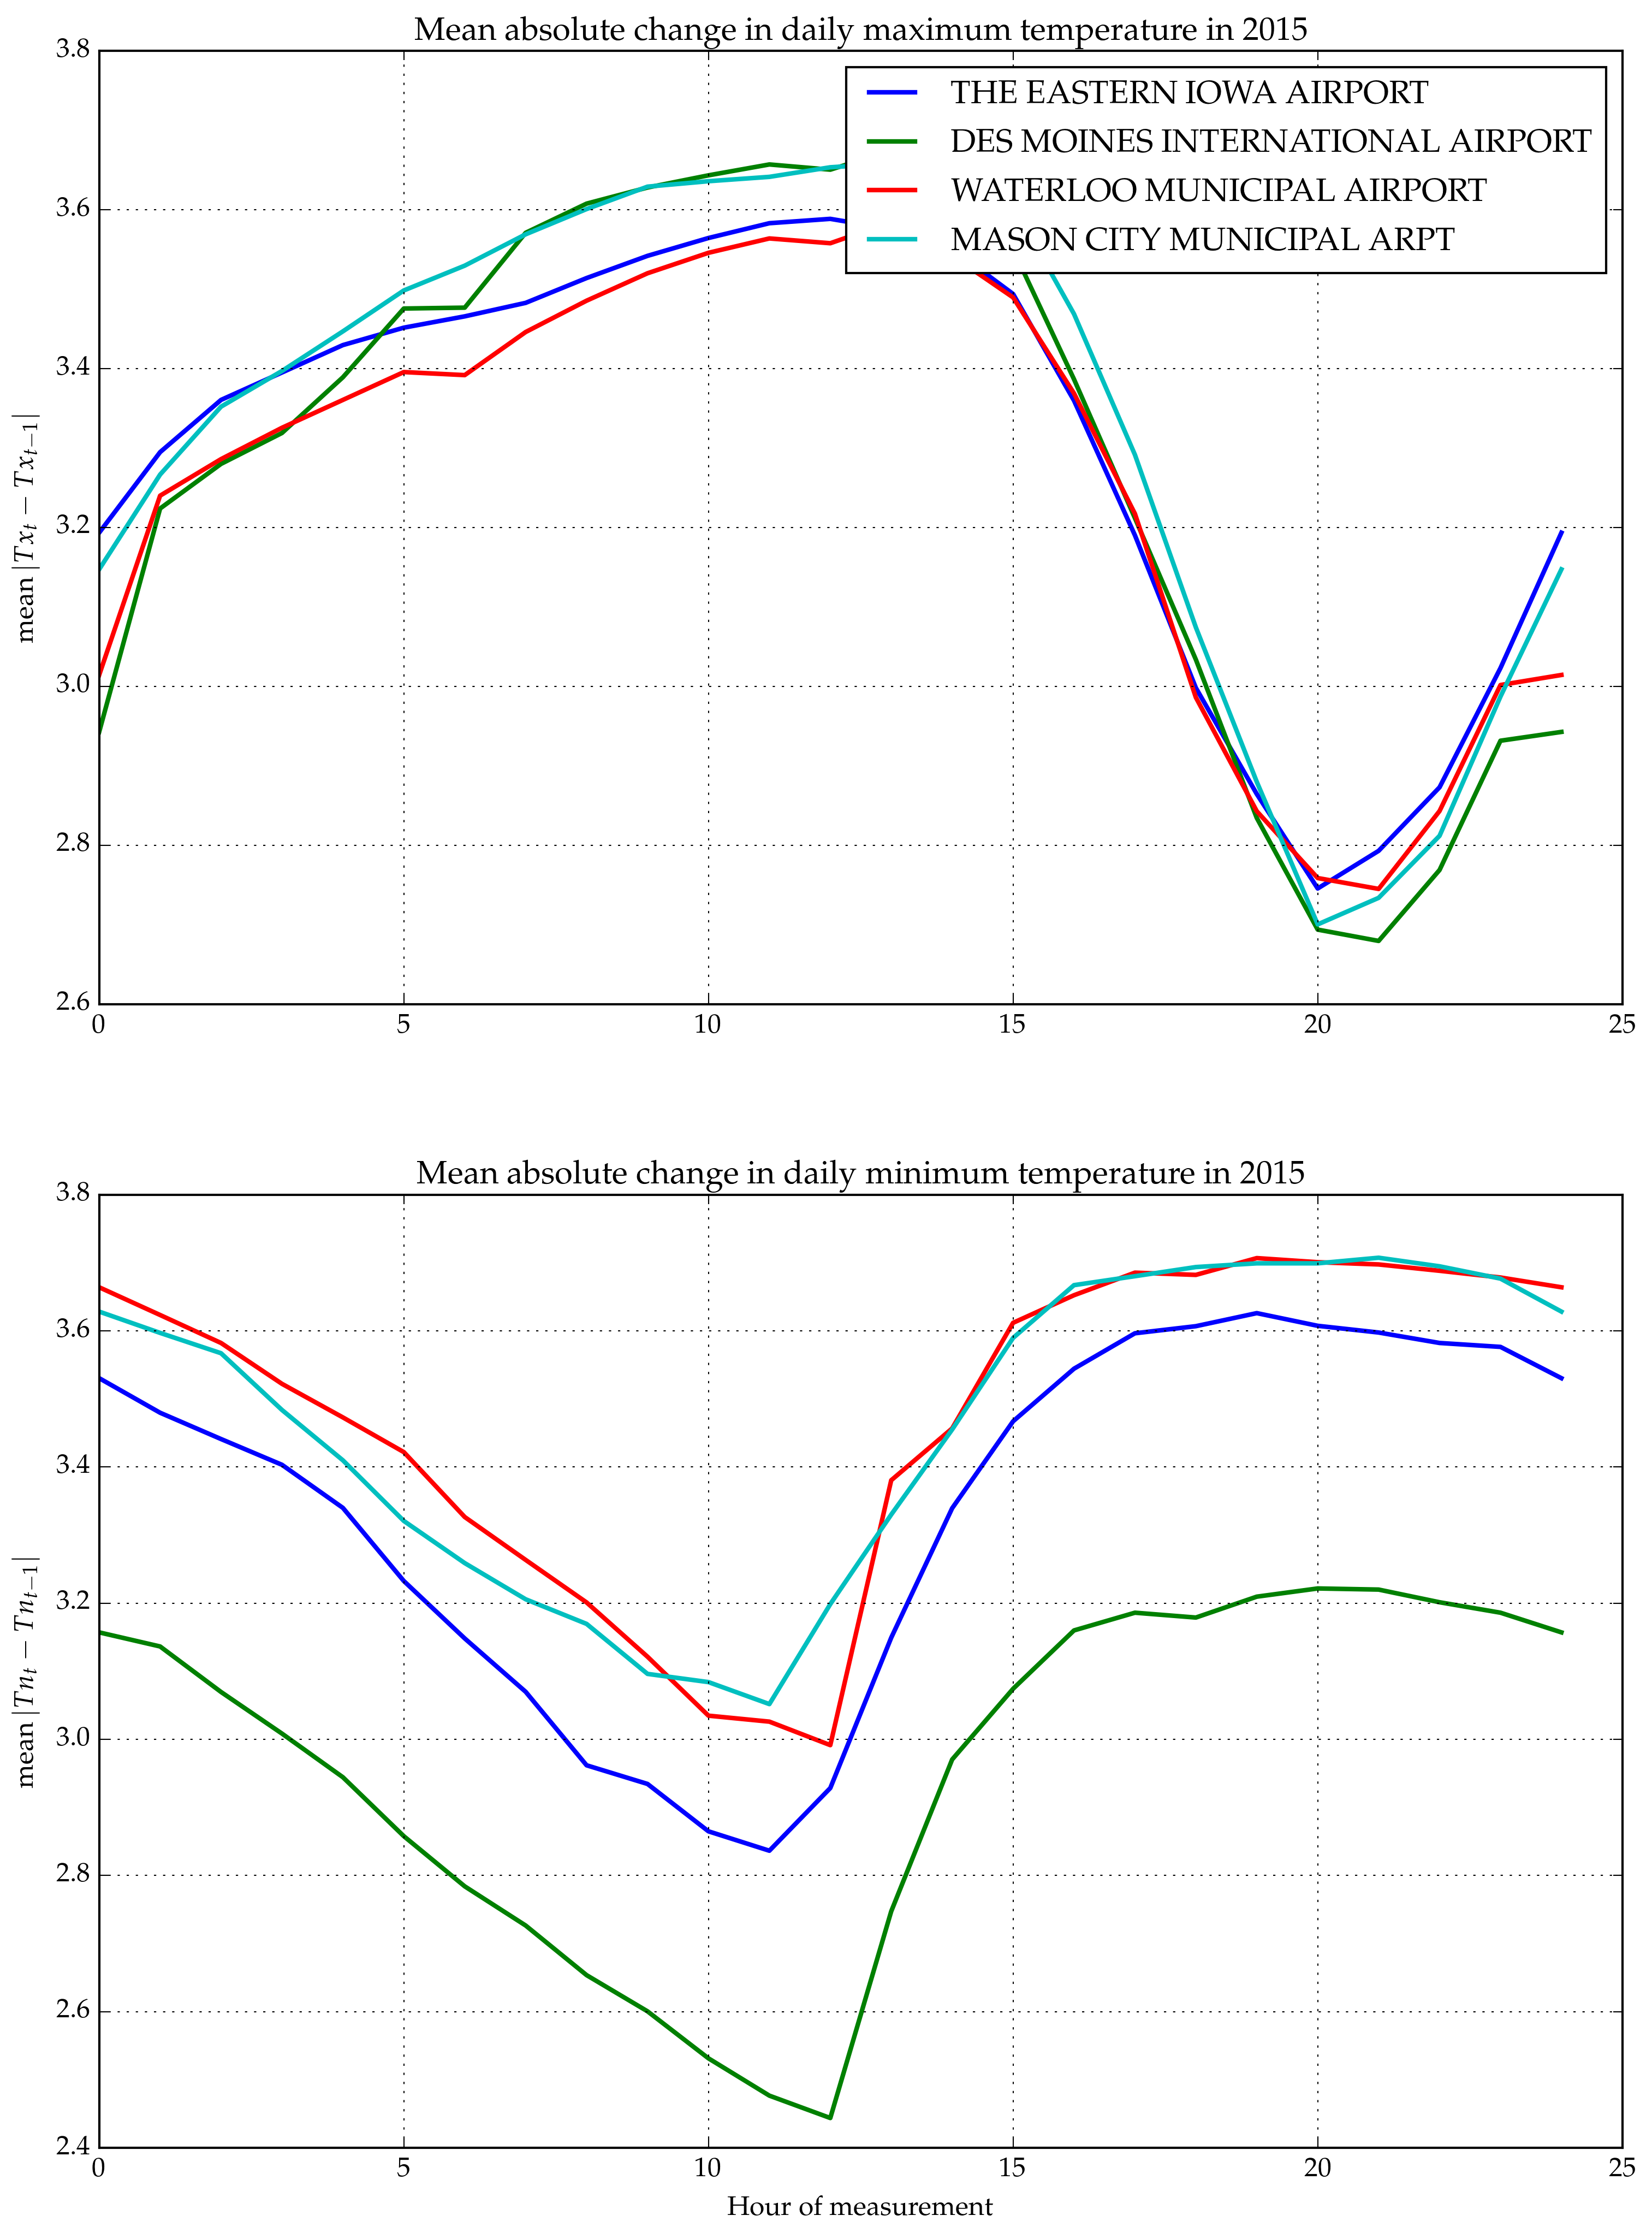

In [49]:
plt.subplot(2,1,1)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(abs(diff(df[:Tx].values))))
        for station in 1:4
            push!(meandiff[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, meandiff[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tx_{t}-Tx_{t-1} \right|$")
    plt.title("Mean absolute change in daily maximum temperature in 2015")
    plt.grid()
    plt.legend()
end
plt.subplot(2,1,2)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(abs(diff(df[:Tn].values))))
        for station in 1:4
            push!(meandiff[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, meandiff[station], linewidth=2)
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tn_{t}-Tn_{t-1} \right|$")
    plt.title("Mean absolute change in daily minimum temperature in 2015")
    plt.xlabel("Hour of measurement")
    plt.grid(true)
end
plt.gcf()[:set_size_inches](12.0, 16.0)
;

# Model Specification

1. start with a simple SE kernel in both space and time $$k_{st}(s,s',t,t') = k_{time}(t,t') \times k_{space}(s,s') + k_{mean}(s,s')$$
3. observation model
    * not much to say... just clipping


# Implementation

1. timeseries model
    * fitting hyperparameters
    * chunks
    * show variogram
2. spatiotemporal model
    * fitting hyperparameters
    * chunks
3. imputations
    * Stan
    * softmin and softmax
    * observation noise
    * reparametrization
    
# Improving model    
1. focused on timeseries model
    * kernel components
    * diurnal cycle
    * show improved variograms
2. spatiotemporal model
    * variograms and cross-variograms
    * trace evolution
        * product kernel
        * sum of products with variance 1
        * sum of products with free variance
    * for each model, report marginal likelihood, and predictive diagnostic in a table
    * discuss importance of getting uncertainty right

# Analysis
* show imputations on interesting days
* show imputations can capture two possible explanations for a measurement
* discuss possibility of inferring measurement time